<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.08/CV6_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터셋 불러오기 - #1

In [ ]:
import os

# 3번 GPU만 사용하고 싶은 경우 예시(cuda:0에 지정)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
from torchvision import transforms
from torchvision.models.resnet import resnet18, ResNet18_Weights
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import cv2

In [ ]:
# gpu를 사용할 수 있으면 gpu, 아니면 cpu 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_path = "/home/knu_ai/workspace/이정철/dataset/train"
test_path = "/home/knu_ai/workspace/이정철/dataset/test"
classes = os.listdir(train_path)
print(f"클래스 {classes}")
print(f"클래스 수: {len(classes)}")

클래스 ['cat', 'otter', 'sea+otter', 'dog']
클래스 수: 4


In [ ]:
# 데이터셋 불러오기 및 전처리
def load_dataset(dataset_path): 
  datum = []
  labels = []

  _classes = os.listdir(dataset_path) # 클래스 폴더들

  for i, cls in enumerate(_classes): # 클래스 폴더들에 대해서 반복
    class_path = os.path.join(dataset_path, cls) # 클래스 폴더 경로
    
    images = os.listdir(class_path) # 클래스 내 이미지들
    for image in images: # 이미지들에 대해서 반복
      image_path = os.path.join(class_path, image) # 이미지 경로

      img = cv2.imread(image_path) # 이미지 읽기

      datum.append(img) # 이미지 데이터
      labels.append(classes.index(cls)) # 레이블 데이터

  return np.array(datum), np.array(labels) # numpy

In [ ]:
train_images, train_labels = load_dataset(train_path)
test_images, test_labels = load_dataset(test_path)

print(f"학습 데이터 수: {len(train_images)}")
print(f"시험 데이터 수: {len(test_images)}")

학습 데이터 수: 16
시험 데이터 수: 4


/tmp/ipykernel_230979/1672915667.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datum), np.array(labels) # numpy


# 데이터셋 및 데이터로더 생성 - #2

In [ ]:
# 커스텀 데이터셋 구성
class MyDataset(Dataset):
  # 이미지, 레이블, 데이터증강 
  def __init__(self, images, labels, augmentation):
    self.images = images
    self.labels = labels
    self.augmentation = augmentation

  # 이미지, 레이블 얻기
  def __getitem__(self, index):
    image = self.augmentation(self.images[index])
    label = self.labels[index]
    return image, label

  # 데이터셋 크기
  def __len__(self):
    return len(self.labels)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256, 256)),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
train_set = MyDataset(train_images, train_labels, transform)
test_set = MyDataset(test_images, test_labels, transform)

batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# 모델 생성 - #3

In [ ]:
# 일반 resnet 생성
model = resnet18(ResNet18_Weights.DEFAULT).to(device)

# CNN Backbone 프리징
for p in model.parameters():
  p.requires_grad = False

# classifier 변경
num_classes = len(classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes).to(device)
model

/home/knu_ai/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 학습 및 평가 - #4

In [ ]:
writer = SummaryWriter('log/resnet18/base')

In [ ]:
def train_and_valid(model, Epoch, learning_rate):
  # optimizer, loss function 설정
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  # 모델 학습 모드
  model.train()

  # 에폭만큼 반복
  for epoch in range(Epoch):
    print(f'Epoch {epoch}:')
    train_loss = 0
    
    ###### 모델 학습 ######
    print(f'Training model...')
    # dataloader를 통한 데이터 불러오기
    for image, label in tqdm(train_loader):
      # 데이터 연산 위치 지정 (GPU or CPU)
      image = image.to(device)
      label = label.to(device)

      # 모델에 입력 (순전파)
      pred = model(image)
      
      # Loss 계산
      loss = criterion(pred, label)

      # 역전파
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 최종 loss 누적
      train_loss += loss.detach().cpu().numpy()

    # 학습 loss 기록
    train_loss /= len(train_loader)
    writer.add_scalar("train_loss", train_loss, epoch)
    print(f'Train Loss: {train_loss}\n')

    ###### 모델 평가 ######
    print(f'Validating model...')
    accuracy = 0
    valid_loss = 0

    # 모델 평가 모드
    model.eval()

    # gradient 계산 차단
    with torch.no_grad():
      # Dataloader로 데이터 불러오기
      for image, label in tqdm(test_loader):
        # 데이터 연산 위치 지정 (GPU or CPU)
        image = image.to(device)
        label = label.to(device)

        # 모델에 입력 (순전파)
        pred = model(image)

        # Loss 계산
        loss = criterion(pred, label)
        
        
        # 최종 loss 누적
        valid_loss += loss.detach().cpu().numpy()

        # 정답 개수 누적
        corr = (pred.argmax(axis=1) == label).sum()
        accuracy += corr.detach().cpu().numpy()

    # 평가 loss 기록
    valid_loss /= len(test_loader)
    writer.add_scalar("valid_loss", valid_loss, epoch)
    print(f'Valid Loss: {valid_loss}')

    # 정확도 계산
    accuracy /= len(test_set)
    print(f'Accuracy: {100*accuracy}%\n')

In [ ]:
train_and_valid(model, Epoch=10, learning_rate=0.001)

Epoch 0:
Training model...


100%|██████████| 16/16 [00:04<00:00,  3.97it/s]


Train Loss: 3.2684526634402573

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Valid Loss: 2.1914602369070053
Accuracy: 25.0%

Epoch 1:
Training model...


100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


Train Loss: 1.8619341515004635

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Valid Loss: 1.2847887128591537
Accuracy: 25.0%

Epoch 2:
Training model...


100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Train Loss: 1.4359828419983387

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Valid Loss: 0.7696098759770393
Accuracy: 75.0%

Epoch 3:
Training model...


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Train Loss: 0.5991690065711737

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Valid Loss: 0.5286082550883293
Accuracy: 100.0%

Epoch 4:
Training model...


100%|██████████| 16/16 [00:02<00:00,  6.44it/s]


Train Loss: 0.3417729213833809

Validating model...


100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Valid Loss: 0.3933796174824238
Accuracy: 100.0%

Epoch 5:
Training model...


100%|██████████| 16/16 [00:02<00:00,  6.24it/s]


Train Loss: 0.22533609066158533

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Valid Loss: 0.3268472235649824
Accuracy: 100.0%

Epoch 6:
Training model...


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Train Loss: 0.15940461540594697

Validating model...


100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Valid Loss: 0.2869540434330702
Accuracy: 100.0%

Epoch 7:
Training model...


100%|██████████| 16/16 [00:02<00:00,  6.08it/s]


Train Loss: 0.12271786690689623

Validating model...


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Valid Loss: 0.2555976966395974
Accuracy: 100.0%

Epoch 8:
Training model...


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Train Loss: 0.0992747365962714

Validating model...


100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


Valid Loss: 0.23207436129450798
Accuracy: 100.0%

Epoch 9:
Training model...


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Train Loss: 0.08265054575167596

Validating model...


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

Valid Loss: 0.21428894996643066
Accuracy: 100.0%



In [ ]:
%load_ext tensorboard
%tensorboard --logdir log/resnet18

In [ ]:
import matplotlib.pyplot as plt

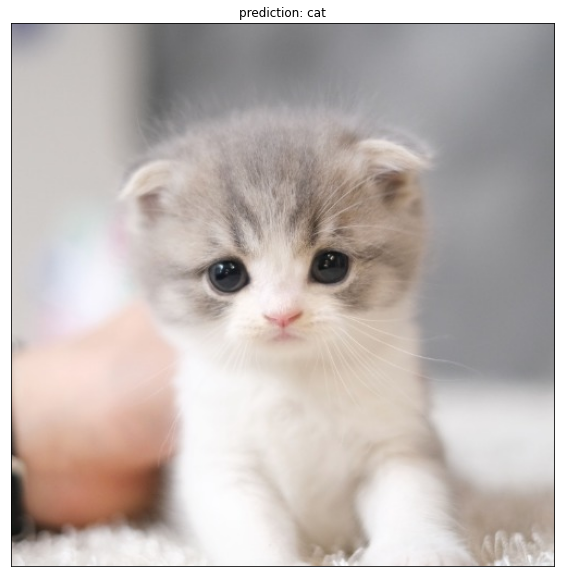

cat: 0.9585175514221191
otter: 0.030838288366794586
sea+otter: 0.002987188519909978
dog: 0.0076570212841033936


In [ ]:
img = test_images[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
t_img = transform(img).to(device)
pred = model(t_img.unsqueeze(0))
cls = classes[pred.argmax()]

plt.figure(figsize=(10, 10))
plt.imshow(img), plt.title(f'prediction: {cls}'), plt.xticks([]), plt.yticks([])
plt.show()

for c, p in zip(classes, nn.Softmax(dim=1)(pred).squeeze()):
    print(f'{c}: {p}')